In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [4]:
df = pd.read_csv("WineQT.csv")

In [5]:
print("Missing values in dataset:\n", df.isnull().sum())

Missing values in dataset:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64


In [6]:
X = df.drop("quality", axis=1)
y = df["quality"]

In [7]:
# Convert target variable into binary classification (Good: 1, Bad: 0)
y = np.where(y >= 6, 1, 0)

In [8]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel="rbf", C=1, gamma='scale', probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss")
}

In [11]:
# Perform cross-validation and evaluate models
results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = np.mean(cv_scores)
    results[model_name] = mean_score
    print(f"{model_name}: Mean CV Accuracy = {mean_score:.4f}")

Logistic Regression: Mean CV Accuracy = 0.7517
Random Forest: Mean CV Accuracy = 0.7844
Gradient Boosting: Mean CV Accuracy = 0.7823
Support Vector Machine: Mean CV Accuracy = 0.7472
K-Nearest Neighbors: Mean CV Accuracy = 0.6958
Decision Tree: Mean CV Accuracy = 0.6980
XGBoost: Mean CV Accuracy = 0.7724


In [12]:
# Train the best model (based on CV results)
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [13]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Model: Random Forest
Test Accuracy: 0.7817
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76       102
           1       0.81      0.80      0.80       127

    accuracy                           0.78       229
   macro avg       0.78      0.78      0.78       229
weighted avg       0.78      0.78      0.78       229



In [14]:
# Hyperparameter Tuning for Best Model (Example for Random Forest)
if best_model_name == "Random Forest":
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    }
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("\nBest Hyperparameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTuned {best_model_name} Accuracy: {accuracy:.4f}")


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Tuned Random Forest Accuracy: 0.7817


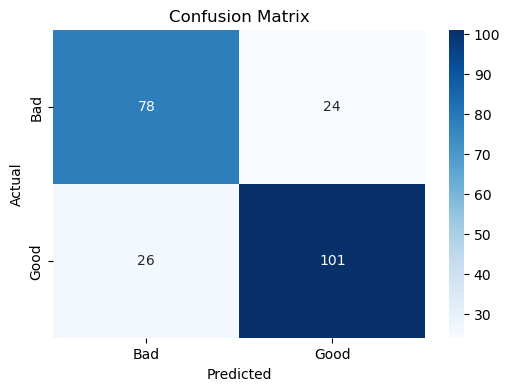

In [15]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

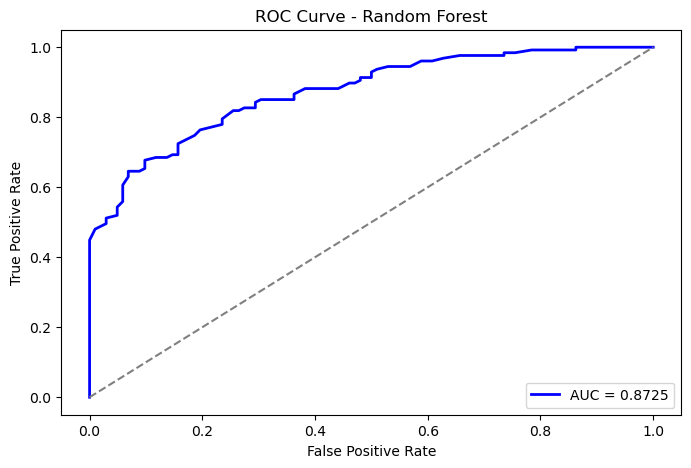

In [16]:
# ROC Curve for Best Model
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model_name}")
plt.legend(loc="lower right")
plt.show()

C:\Users\aadhi\AppData\Local\Temp\ipykernel_8416\869118129.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


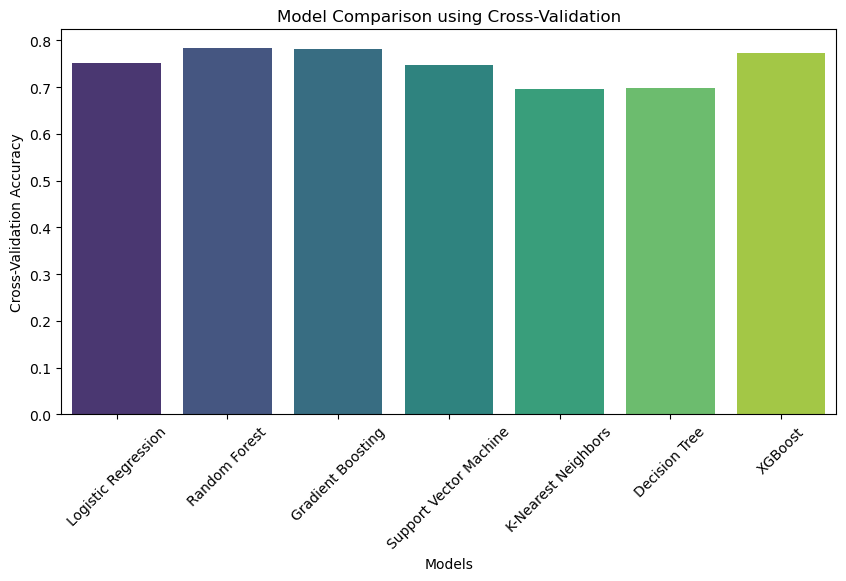

In [17]:
# Visualize Model Performance
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.xlabel("Models")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Model Comparison using Cross-Validation")
plt.xticks(rotation=45)
plt.show()